# 09-A. MNISTを用いた文字認識（MLP）


---
## 目的
多層パーセプトロン（MLP）を用いてMNISTデータセットに対する文字認識を行う．
評価はConfusion Matrixにより各クラスの認識率を用いて行う．

## 使用するデータセット
今回の文字認識では，MNIST Datasetを用いる．[MNIST Dataset](http://yann.lecun.com/exdb/mnist/)は，0から9までの数字が記述されている画像から構成されたデータセットである．MNIST Datasetの文字画像は，以下のように白黒で比較的認識しやすいように画像処理されている．

![MNIST_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/143078/559938dc-9a99-d426-010b-e000bca0aac6.png)

## モジュールのインポート
はじめに必要なモジュールをインポートする．

今回は`chainer`をインポートする．

In [ ]:
from time import time
import numpy as np
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L

## データセットの読み込みと確認
学習データ（MNIST Dataset）を読み込みます．

読み込んだ学習データのサイズを確認します．
学習データ数は6万枚．1つのデータのサイズは786次元となっています．

In [ ]:
train_dataset, test_dataset = chainer.datasets.get_mnist()
train_x,train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


### MNISTデータセットの表示

MNISTデータセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

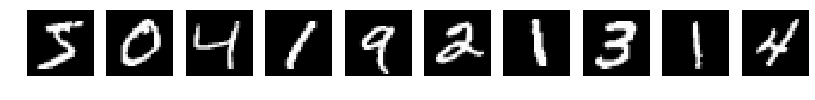

In [ ]:
import matplotlib.pyplot as plt

cols = 10

plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(cols):
    ax = fig.add_subplot(1, cols, c + 1)
    ax.imshow(train_x[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()
plt.show()

## ネットワークモデルの定義

ニューラルネットワークを定義します．
ここでは，入力層，中間層，出力層から構成される３層のニューラルネットワークとします．

入力層のユニット数は入力データのサイズによります．
ここではNoneとし，データにより変更できるようにしておきます．

中間層と出力層のユニット数は引数として与え，それぞれn_units，n_outとします．
Chainerでは，\__init\__関数にこれらの引数を与えて各層を定義します．
各層はLinear関数としています．これは全結合層を意味しています．

そして，\__call\__関数で定義した層を接続して処理するように記述します．
\__call\__関数の引数xは入力データです．
それを\__init\__関数で定義したl1という中間層に与え，その出力を活性化関数であるrelu関数に与えます．その出力をh1としています．h1は出力層h2に与えられ，その出力をh2としています．

In [ ]:
class MLP(chainer.Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(n_units, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

まず，中間層と出力層のユニット数を定義します．
ここでは，中間層のユニット数（n_units）を50，出力層のユニット数（out_units）を10とします．

各層のユニット数をMLP関数の引数として与え，ネットワークモデルを定義します．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.01，モーメンタムを0.9として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．



In [ ]:
# ユニット数の定義
n_units = 50
out_units = 10

# ネットワークの作成
model = MLP(n_units=n_units, n_out=out_units)

# 最適化手法の設定
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．

学習を開始します．
MNISTの学習データサイズを取得し，1エポック内における更新回数を求めます．
学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．
各更新において，学習用データと教師データをそれぞれxとtとします．
学習モデルにxを与えて各クラスの確率yを取得します．
各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [ ]:
# ミニバッチサイズ・エポック数．学習データ数の設定
batch_size = 100
epoch_num = 10
train_data_num = train_x.shape[0]

# 学習の実行
for epoch in range(epoch_num):
    sum_loss = 0
    sum_accuracy = 0
    perm = np.random.permutation(train_data_num)
    for i in range(0, train_data_num, batch_size):
        x = Variable(train_x[perm[i:i+batch_size]])
        t = Variable(train_y[perm[i:i+batch_size]])

        model.zerograds()
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)

        acc = F.accuracy(y, t)

        loss.backward()
        optimizer.update()

        sum_loss += loss.data*batch_size
        sum_accuracy += acc.data*batch_size

    print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))

epoch: 1, mean loss: 0.4997894151012103, mean accuracy: 0.8636833347876867
epoch: 2, mean loss: 0.2628886147712668, mean accuracy: 0.9242500020066897
epoch: 3, mean loss: 0.21528200936814149, mean accuracy: 0.9381833353638649
epoch: 4, mean loss: 0.18603893416002393, mean accuracy: 0.9471666679779689
epoch: 5, mean loss: 0.16474373631179332, mean accuracy: 0.9529000022013983
epoch: 6, mean loss: 0.14779339289292692, mean accuracy: 0.9587166697780292
epoch: 7, mean loss: 0.13532202234491705, mean accuracy: 0.961350003083547
epoch: 8, mean loss: 0.12368039255340894, mean accuracy: 0.9651166712244351
epoch: 9, mean loss: 0.11476841354121764, mean accuracy: 0.9674833403031031
epoch: 10, mean loss: 0.10658274720733364, mean accuracy: 0.9702000058690707


## テスト

学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

In [ ]:
count = 0
test_data_num = test_x.shape[0]

for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        count += 1

print("test accuracy: {}".format(count/test_data_num))

test accuracy: 0.9668


## 課題
1. ネットワークの構造を変えて実験しましょう．
    * まず，中間層のユニット数を200個にしましょう．
    * 次に，中間層を1層増やしましょう．その際， 中間層のユニット数は200個としましょう．

2. エポック数やミニバッチサイズを変えて実験しましょう．
    * まず，ミニバッチサイズを128にしましょう．
    * 次に，エポック数を50に増やしてみましょう．

## 別のプログラムの書き方
ここまでのコードは学習の流れをわかりやすくするために，エポックまたはミニバッチ毎にfor文で学習を行うようにプログラムを作成しました．
chainerでは，trainerとupdaterという繰り返し処理を抽象化するクラスが用意されています．
これらを利用した場合は，以下のように書くことができます．

1. SerialIteratorにより学習および評価データを繰り返し取得することができます．

2. StarndardUpdaterは，SerialIteratorによって繰り返し取得したデータをoptimizerに渡してmodelをアップデートします．

3. TrainerはこのUpdaterの処理を指定されたエポック回数分行い，学習したモデルをresultに保存できます． Trainerにはさまざなま拡張機能を追加できます．

4. Evaluatorは学習したモデルを評価する機能であり，LogReportは学習時のロスは精度を記憶します．これらの記憶されているログをPlotReportが表示したりグラフとして保存したりします．

5. 学習の実行はtrainerクラスのrun関数により行います．

In [ ]:
from chainer import training
from chainer.training import extensions

batch_size = 100
epoch_num = 10

n_units = 50
out_units = 10

model = L.Classifier(MLP(n_units, out_units))
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_mnist()

# 1. SerialIterator
train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size, repeat=False, shuffle=False)

# 2. StandardUpdater
updater = training.updaters.StandardUpdater( train_iter, optimizer, device=-1)

# 3. Trainer
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

# 4. Evaluator
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                                     'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                                     'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                                       'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# 5. 学習の実行
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.491238    0.289738              0.864517       0.9165                    2.30586       
2           0.262965    0.226646              0.924783       0.9353                    5.87707       
3           0.212222    0.193569              0.939533       0.9446                    9.41284       
4           0.180991    0.167073              0.9481         0.9506                    13.0606       
5           0.158313    0.154387              0.9548         0.9557                    16.7924       
6           0.141008    0.141487              0.959917       0.9595                    20.5325       
7           0.12738     0.127749              0.9634         0.9611                    24.3572       
8           0.116847    0.120854              0.965767       0.9623                    28.1758       
9           0.107698    0.114529              0.9689         0.9643                 